# Step 3 - Use Model as a Predictor

After a Neural Network has been trained, we could use it as a predictor on new geometries or new simulation conditions. As an illustration, we use this framework on the dataset it was trained on. 

This notebook illustrates how to:
- Create a dataset loader on geometries
- How to use the neural network to predict State-of-Lithiation for a full galvanostatic discharge
- Visualize predictions with SoL-maps and SoL-profiles

## Import Modules

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('../../li2d'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from postprocessing.ml import Microstructure_to_ETL as micro_to_dataset_loader
from postprocessing.ml import electrode_sol_map_from_predictions

from postprocessing.evaluate import save_color_img
from postprocessing.evaluate import plot_sol_profile

from utils.io import load_json
from utils.image import electrode_mask_2D

In [3]:
import tensorflow as tf
import numpy as np
from skimage import io

import matplotlib.pyplot as plt

import time
import os

### Define Filename Format of COMSOL SoLmaps

In [4]:
def format_filename(
    path: str, 
    c_rate: str,
    time: int,
):
    fname = "c%s_t%s.npy" % (c_rate, time)
    filepath = os.path.join(path, fname)
    return filepath

## Experiments Conducted on Microstructure

This dictionary defines the (C-rate, time (s)) of the electrochemical simulations on "Microstructure 1" as defined in the `metadata.json` file. We will compare results between the trained Neural Network and ground-truth COMSOL data.

In [5]:
experiments = {
    1: {
        "0.25": [
            (0.25, 0),
            (0.25, 1200),
            (0.25, 2400),
            (0.25, 3600),
            (0.25, 4800),
            (0.25, 6000),
            (0.25, 7200),
            (0.25, 8400),
            (0.25, 9600),
            (0.25, 10800),
            (0.25, 12000),
            (0.25, 13200),
            (0.25, 13516),
        ],
        "0.5": [
            (0.5, 0),
            (0.5, 600),
            (0.5, 1200),
            (0.5, 1800),
            (0.5, 2400),
            (0.5, 3000),
            (0.5, 3600),
            (0.5, 4200),
            (0.5, 4800),
            (0.5, 5400),
            (0.5, 6000),
            (0.5, 6600),
            (0.5, 6729.2),
        ],
        "1": [
            (1, 0),
            (1, 300),
            (1, 600),
            (1, 900),
            (1, 1200),
            (1, 1500),
            (1, 1800),
            (1, 2100),
            (1, 2400),
            (1, 2700),
            (1, 3000),
            (1, 3300),
        ],
        "2": [
            (2, 0),
            (2, 150),
            (2, 300),
            (2, 450),
            (2, 600),
            (2, 750),
            (2, 900),
            (2, 1050),
            (2, 1200),
            (2, 1350),
            (2, 1500),
            (2, 1605.9),
        ],
        "3": [
            (3, 0),
            (3, 100),
            (3, 200),
            (3, 300),
            (3, 400),
            (3, 500),
            (3, 600),
            (3, 700),
            (3, 800),
            (3, 900),
        ],
    },
}

## Load Trained Machine Learning Model

In [6]:
model = tf.keras.models.load_model(
    "99x99 - Final Model.keras", 
    compile=False,
)

2022-08-22 09:30:25.675464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-22 09:30:25.675583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


## Settings for the Machine Learning ETL and PostProcessing Functionalities

Define the parameters used to train the Neural Network. We will use these parameters for estimation (prediction) for State-of-Lithiation in NMC111 particles during galvanostatic discharge.

In [7]:
# Cell normalizations
L = 176
h_cell = 100
R_max = 10
zoom_norm = 9
c_rate_norm = 3
time_norm = 14400

# Image settings
width_wrt_radius = 3
scale = 5
img_size = 99
order_zoom = 0

# Parameters for ML model
tf_img_size = 99
batch_size = 32
norm_metadata = {
    "L": L, 
    "h_cell": h_cell,
    "R_max": R_max, 
    "zoom_norm": zoom_norm,
    "c_rate_norm": c_rate_norm, 
    "time_norm": time_norm,
}
pore_encoding = 65535
padding_encoding = 0

f_data = load_json("metadata.json")
user_params = (width_wrt_radius, scale, img_size, order_zoom)

## Use the Machine Learning Model and Do some Post Processing

### Setup

In [8]:
# Include up to 0.99 of the particle. Borders could have large errors
R_factor = 0.99

L_arr = [176]

## Would add more "micro num" if one wanted to predict SoL on more microstructures. So something like:
## micro_num = [1, 2, 3, 4, 5]
micro_num = 1

###########
## SETUP ##
###########
circle_data = f_data[micro_num - 1]["circles"]
micro_data = ("micro_%d.npy" % micro_num, L_arr[micro_num - 1], h_cell)

## Create electrode mask
electrode_mask = electrode_mask_2D(
    circle_data,
    L_arr[micro_num - 1],
    h_cell,
    R_factor=R_factor,
    scale=scale,
)

## Grep rings
electrode_rings = electrode_mask_2D(
    circle_data,
    L_arr[micro_num - 1],
    h_cell,
    R_factor=R_factor,
    scale=scale,
    mode="ring",
)

## Create a ETL Dataset loader
#  In this step the microstructure is split into particles and its surroundings.
#  Each particle is zoomed into so all particles are centered at roughly the same size.
#  Zooming is the bottleneck, so this is done first.
#
#  Within the nested `for` loop, the time and C-rate is specified so there is a dataloader
#  for each time and C-rate.
input_imgs = micro_to_dataset_loader(
    tf_img_size,
    batch_size,
    norm_metadata,
    circle_data,
    micro_data,
    pore_encoding,
    padding_encoding,
    user_params,
)

344it [00:00, 1493.06it/s]


### Use the Machine Learning Framework on a Full Discharge

In [9]:
## For more discharges: ["0.25", "0.5", "1", "2", "3"]

for discharge in ["3"]:
        
    studied_timesteps = experiments[micro_num][discharge]

    ##############################
    ## Generate Dataset Loaders ##
    ##############################
    img_datasets = []

    start_time = time.time()

    for c_rate, timestep in studied_timesteps:
        img_datasets.append(input_imgs.get_loader(
            c_rate,
            float(timestep),
        ))

    print("It took %s seconds to generate all dataset loaders for the specified timesteps" % (time.time() - start_time))

    ################################################
    ## Use ML Model to Predict on Dataset Loaders ##
    ################################################
    predicted_imgs = []
    start_time = time.time()

    for idx, _ in enumerate(studied_timesteps):
        predictions = model.predict(img_datasets[idx])
        predicted_imgs.append(predictions)

    print("It took %s for the ML network to predict on all specified timesteps" % (time.time() - start_time))

    #####################################################
    ## "Patch" Images from Machine Learning Prediction ##
    #####################################################
    predicted_colormaps = []
    start_time = time.time()

    for idx, _ in enumerate(studied_timesteps):

        colormap = electrode_sol_map_from_predictions(
            img_datasets[idx],
            predicted_imgs[idx],
            L_arr[micro_num - 1],
            (L, h_cell, R_max, zoom_norm, 0, 0),
            scale = scale,
            grid_size = 300,
        )
        colormap = colormap
        predicted_colormaps.append(colormap)

    print("It took %s to reconstruct colormaps from Machine Learning predictions" % (time.time() - start_time))

    ########################
    ## Load COMSOL Images ##
    ########################
    comsol_colormaps = []
    start_time = time.time()

    for idx, tup in enumerate(studied_timesteps):
        c_rate, timestep = tup

        path = os.path.join(os.getcwd(), "%d/col" % micro_num)
        fname = format_filename(
            path,
            str(c_rate),
            timestep,
        )

        colormap = np.load(fname)
        comsol_colormaps.append(colormap)

    print("It took %s second to load files from disk" % (time.time() - start_time))

It took 87.36701893806458 seconds to generate all dataset loaders for the specified timesteps


2022-08-22 09:31:55.521028: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/11 [=>............................] - ETA: 5s

2022-08-22 09:31:55.789077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 29ms/step
It took 5.919034719467163 for the ML network to predict on all specified timesteps
It took 8.84750509262085 to reconstruct colormaps from Machine Learning predictions
It took 0.013094902038574219 second to load files from disk


### State-of-Lithiation Map

In [10]:
time_idx = 5

path = os.getcwd()

save_color_img(
    predicted_colormaps[time_idx],
    comsol_colormaps[time_idx],
    os.getcwd(), 
    timestep,
)

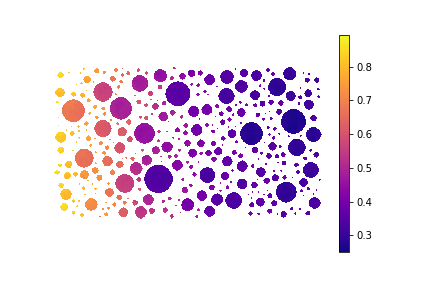

In [12]:
from IPython.display import Image

Image(filename='ml_900.png') 

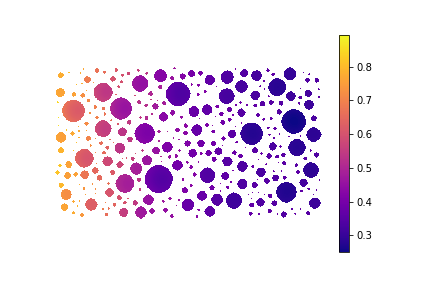

In [13]:
Image(filename='comsol_900.png') 

### State-of-Lithiation Profiles across Electrode Length

In [14]:
path = os.getcwd()

plot_sol_profile(
    predicted_colormaps[time_idx],
    comsol_colormaps[time_idx],
    os.getcwd(),
    timestep,
    scale=scale,
)

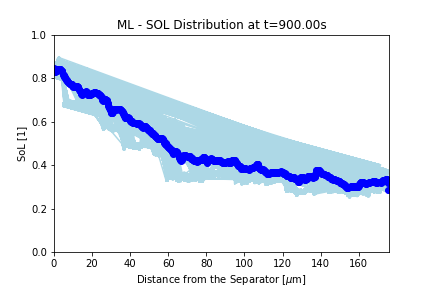

In [15]:
Image(filename='ML_sol_dist_900.png') 

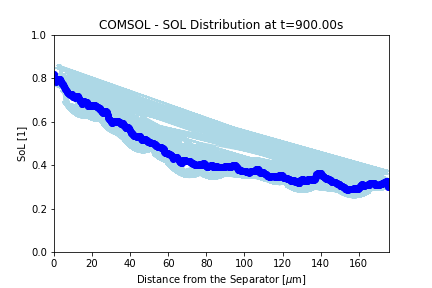

In [16]:
Image(filename='COMSOL_sol_dist_900.png') 

### Particle-Size Distribution of Microstructure 1

Text(0.5, 1.0, 'Particle Size Distribution')

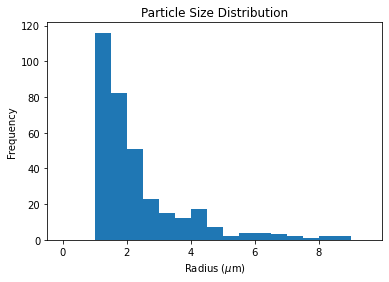

In [17]:
radii = [float(c['R']) for c in f_data[0]["circles"]]

n, bins, patches = plt.hist(x=radii, bins=[r*0.5 for r in range(0, 20)])
plt.xlabel('Radius ($\mu$m)')
plt.ylabel('Frequency')
plt.title('Particle Size Distribution')

### Visualize Predicted State-of-Lithiation Map Directly

This does not remove part of the boundaries defined by `R_factor`.

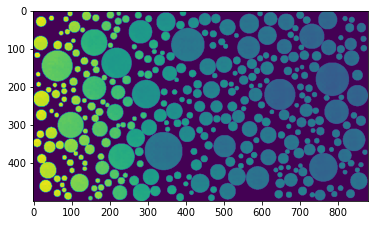

In [18]:
plt.imshow(predicted_colormaps[5])